<a href="https://colab.research.google.com/github/katterine2558/ods-semantic-hub/blob/main/ods_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SOLUCIÓN MICROPROYECTO 2

Por: *Leonardo Almanza y Katerine Arias*

## 1. Importar librerías

En esta etapa inicial se realiza la importación de las librerías esenciales para el desarrollo de una solución automatizada de clasificación de textos orientada a los 17 Objetivos de Desarrollo Sostenible (ODS). Se incorporan herramientas clave para la manipulación y análisis de datos (Pandas, NumPy), el procesamiento de lenguaje natural (NLTK, con word_tokenize, stopwords y PorterStemmer), la extracción de características textuales (CountVectorizer, TfidfVectorizer), la implementación de algoritmos de aprendizaje supervisado (Regresión Logística) y la aplicación de técnicas de reducción de dimensionalidad (PCA, TruncatedSVD). Estas bibliotecas permiten transformar los textos en representaciones vectoriales bajo el esquema de bolsa de palabras (BOW) con ponderación TF-IDF, aplicar métodos de reducción para controlar la alta dimensionalidad del espacio de entrada y, finalmente, construir modelos capaces de realizar clasificación automática de manera eficiente.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# NLTK para procesamiento de texto
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk

# Scikit-learn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin


In [2]:
try:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('punkt_tab')
    print("Recursos NLTK descargados exitosamente")
except:
    print("Algunos recursos de NLTK no se pudieron descargar")

print("Librerías importadas exitosamente")

Recursos NLTK descargados exitosamente
Librerías importadas exitosamente


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## 2. Análisis exploratorio de datos

En esta etapa se realiza la exploración inicial del conjunto de datos, cargando la información desde un archivo Excel y verificando su estructura, columnas disponibles y distribución de las clases asociadas a los Objetivos de Desarrollo Sostenible (ODS). Posteriormente, se lleva a cabo un análisis descriptivo que incluye la revisión de valores nulos, la generación de estadísticas básicas de los textos (longitud en caracteres y número de palabras) y la visualización de la distribución de las clases mediante gráficos de barras y diagramas de pastel. Adicionalmente, se analiza la variabilidad en el tamaño de los textos a través de histogramas, lo cual permite obtener una visión preliminar sobre la calidad, balance y características principales del dataset antes de aplicar técnicas de preprocesamiento y modelado.

###2.1. Información del dataset

El conjunto de datos cuenta con 9.656 registros distribuidos en dos columnas: textos, que contiene los fragmentos a analizar, y ODS, que representa la categoría correspondiente al Objetivo de Desarrollo Sostenible. Adicionalmente se verifica que no hay valores nulos y tampoco hay duplicados.

In [3]:
# Cargar datos
df = pd.read_excel('data.xlsx')

#Se crea copia sobre el dataset original
data_raw = df.copy()

print("=== INFORMACIÓN DEL DATASET ===")
print(f"Tamaño del dataset: {df.shape}")
print(f"Columnas: {list(df.columns)}")
print("\nPrimeras 5 filas:")
print(df.head())

# Verificar valores nulos
print(f"\nValores nulos:")
print(df.isnull().sum())

#Verificar duplicados
print(f"\nDuplicados:")
print(df.duplicated().sum())



=== INFORMACIÓN DEL DATASET ===
Tamaño del dataset: (9656, 2)
Columnas: ['textos', 'ODS']

Primeras 5 filas:
                                              textos  ODS
0  "Aprendizaje" y "educación" se consideran sinó...    4
1  No dejar clara la naturaleza de estos riesgos ...    6
2  Como resultado, un mayor y mejorado acceso al ...   13
3  Con el Congreso firmemente en control de la ju...   16
4  Luego, dos secciones finales analizan las impl...    5

Valores nulos:
textos    0
ODS       0
dtype: int64

Duplicados:
0


### 2.2. Distribución de la variable target

La distribución de los textos por ODS evidencia un desbalance en las clases, con mayor concentración en los ODS 4, 5 y 16, mientras que otros presentan una representación considerablemente menor. Además, aunque el enunciado menciona 17 ODS, el dataset solo contiene 16 categorías, por lo que la clasificación se realizará bajo estos 16 objetivos.


Distribución de clases (ODS):
ODS
1      505
2      369
3      894
4     1025
5     1070
6      695
7      787
8      446
9      343
10     352
11     607
12     312
13     464
14     377
15     330
16    1080
Name: count, dtype: int64


Text(0.5, 1.0, 'Distribución Porcentual por ODS')

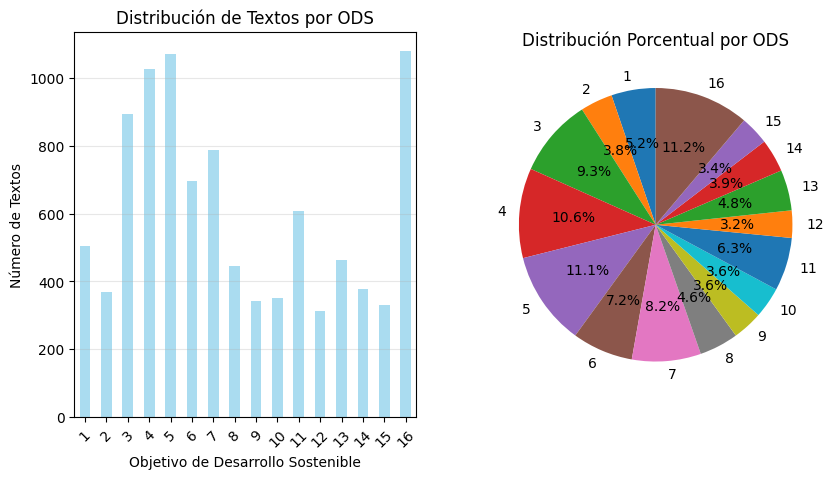

In [4]:
print(f"\nDistribución de clases (ODS):")
ods_counts = df['ODS'].value_counts().sort_index()
print(ods_counts)

# Visualización básica con matplotlib
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
ods_counts.plot(kind='bar', color='skyblue', alpha=0.7)
plt.title('Distribución de Textos por ODS')
plt.xlabel('Objetivo de Desarrollo Sostenible')
plt.ylabel('Número de Textos')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 3, 2)
plt.pie(ods_counts.values, labels=ods_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribución Porcentual por ODS')

### 2.3. Otros análisis

El análisis de la longitud de los textos muestra que, en promedio, cada registro contiene alrededor de 709 caracteres y 111 palabras. El texto más corto cuenta con 143 caracteres, mientras que el más extenso alcanza los 1977. La distribución del número de palabras presenta una forma cercana a una campana, concentrando la mayoría de los textos entre 70 y 130 palabras. Esta información es relevante, ya que permite dimensionar el tamaño típico de los textos y anticipar la complejidad del procesamiento posterior.

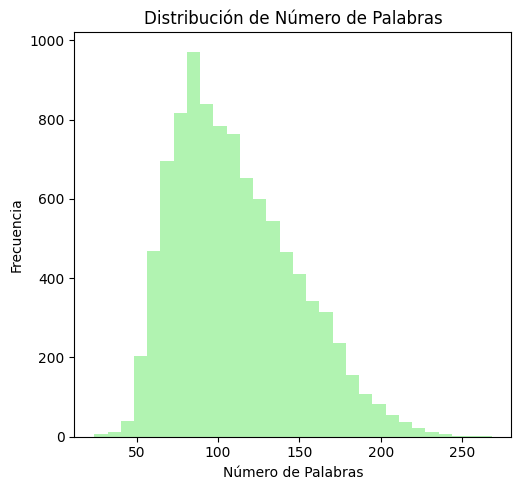


=== ESTADÍSTICAS DE TEXTO ===
Longitud promedio de caracteres: 709.0
Longitud promedio de palabras: 111.0
Texto más corto: 143 caracteres
Texto más largo: 1977 caracteres


In [5]:
# Estadísticas básicas de texto
df['longitud_texto'] = df['textos'].str.len()
df['num_palabras'] = df['textos'].str.split().str.len()

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 3)
plt.hist(df['num_palabras'], bins=30, alpha=0.7, color='lightgreen')
plt.title('Distribución de Número de Palabras')
plt.xlabel('Número de Palabras')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

print(f"\n=== ESTADÍSTICAS DE TEXTO ===")
print(f"Longitud promedio de caracteres: {df['longitud_texto'].mean():.1f}")
print(f"Longitud promedio de palabras: {df['num_palabras'].mean():.1f}")
print(f"Texto más corto: {df['longitud_texto'].min()} caracteres")
print(f"Texto más largo: {df['longitud_texto'].max()} caracteres")

## 3. Preprocesamiento de textos

El preprocesamiento de textos constituye una etapa fundamental para garantizar la calidad de los datos antes de su vectorización y posterior modelado:

1. **Limpieza**: el texto es normalizado para reducir ruido y homogenizar la información.
2. **Tokenización**: divide el texto en unidades mínimas de análisis (palabras o tokens).
3. **Eliminación de stopwords**: elimina aquellas palabras sin valor semántico relevante para la clasificación.
4. **Stemming**: técnica que reduce las palabras a sus raíces para agrupar variantes morfológicas y disminuir la dimensionalidad del vocabulario.


### 3.1. Procesador de texto

Se implementa un transformador personalizado compatible con pipelines de scikit-learn que normaliza el texto, elimina caracteres especiales, tokeniza, remueve stopwords y aplica stemming, generando una versión depurada y lista para la vectorización.

In [6]:
STOP_WORDS = set(stopwords.words("spanish"))

class TextPreprocessor(BaseEstimator, TransformerMixin):
    """
    Transformador personalizado para preprocesamiento de texto
    Integrable en pipelines de sklearn
    """

    def __init__(self, language="spanish"):
        self.language = language
        self.stop_words = STOP_WORDS
        self.stemmer = PorterStemmer()

    def fit(self, X, y=None):
        # No hay parámetros que ajustar
        return self

    def transform(self, X):
        """
        Aplica preprocesamiento completo a una serie de textos
        """
        return X.apply(self._preprocess_text)

    def _preprocess_text(self, text):
        """
        Función de preprocesamiento integrada en el transformador
        """
        if pd.isna(text):
            return ""

        # Convertir a minúsculas
        text = text.lower()

        # Eliminar caracteres especiales, conservar solo letras y espacios
        text = re.sub(r'[^a-záéíóúñü\s]', ' ', text)

        # Eliminar espacios múltiples
        text = re.sub(r'\s+', ' ', text)

        # Tokenización
        try:
            tokens = word_tokenize(text, language=self.language)
        except:
            tokens = word_tokenize(text)

        # Eliminar stopwords, palabras cortas y aplicar stemming
        tokens = [self.stemmer.stem(word) for word in tokens
                  if word not in self.stop_words and len(word) > 2]

        return ' '.join(tokens)


Se crea el objeto del preprocesador:

In [7]:
text_preprocessor = TextPreprocessor(language='spanish')

### 3.2. Test de transformador

Se probó el transformador en una muestra de textos para verificar su funcionamiento. Los resultados muestran cómo los textos originales fueron normalizados, tokenizados, depurados de stopwords y reducidos mediante stemming.

In [8]:
print("\n=== EJEMPLOS DE PREPROCESAMIENTO CON TRANSFORMADOR ===")

# Seleccionar algunos textos para demostrar
textos_ejemplo = df['textos'].head(3)

print("Aplicando transformador a textos de ejemplo...")
textos_procesados = text_preprocessor.transform(textos_ejemplo)
for i in range(len(textos_ejemplo)):
    print(f"\nEjemplo {i+1}:")
    print(f"Original: {textos_ejemplo.iloc[i][:200]}...")
    print(f"Procesado: {textos_procesados.iloc[i][:200]}...")


=== EJEMPLOS DE PREPROCESAMIENTO CON TRANSFORMADOR ===
Aplicando transformador a textos de ejemplo...

Ejemplo 1:
Original: "Aprendizaje" y "educación" se consideran sinónimos de escolarización formal. Las organizaciones auxiliares, como las editoriales de educación, las juntas examinadoras y las organizaciones de formació...
Procesado: aprendizaj educación consideran sinónimo escolarización formal organizacion auxiliar editorial educación junta examinadora organizacion formación docent consideran extension acuerdo establecido gobier...

Ejemplo 2:
Original: No dejar clara la naturaleza de estos riesgos puede dar lugar a un exceso de inversión en empresas dependientes del agua y a peticiones de compensación cuando haya que reducir los derechos para evitar...
Procesado: dejar clara naturaleza riesgo pued dar lugar exceso inversión empresa dependient agua peticion compensación reducir derecho evitar compromet calidad agua resultado medioambiental ejemplo fundament evi...

Ejemplo 3:
Ori

### 3.3. Análisis del transformador

El análisis comparativo entre los textos originales y procesados muestra una reducción significativa en su longitud. En promedio, la cantidad de caracteres disminuyó a 472.9 y el número de palabras a 56.5, lo que representa una reducción global del 33.3%. Los histogramas confirman esta tendencia, evidenciando cómo el preprocesamiento depura el contenido eliminando ruido y manteniendo únicamente la información más relevante para el modelado.



=== ESTADÍSTICAS DEL PREPROCESAMIENTO ===
Longitud promedio después de procesamiento: 472.9 caracteres
Palabras promedio después de procesamiento: 56.5
Reducción de longitud: 33.3%


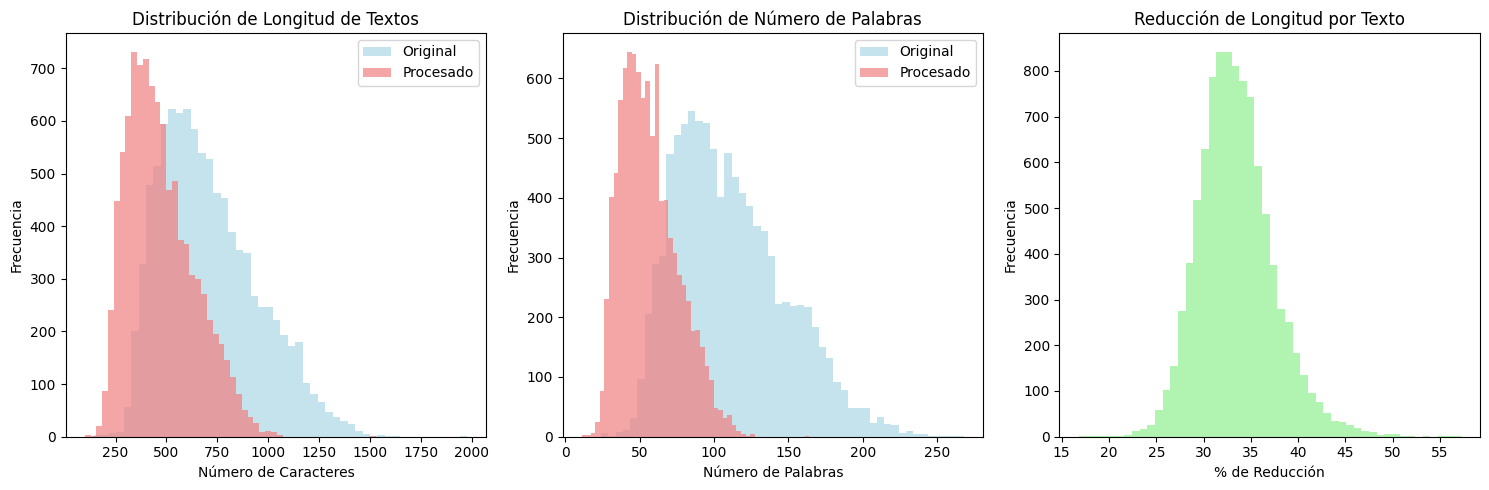

In [9]:

# Estadísticas del preprocesamiento
# Métricas originales
df['longitud_texto'] = df['textos'].str.len()
df['num_palabras'] = df['textos'].str.split().str.len()

# Aplica preprocesador y asegúrate de que quede como string
df['texto_procesado_transformer'] = text_preprocessor.transform(df["textos"]).apply(lambda x: " ".join(x) if isinstance(x, list) else str(x))

# Métricas procesadas
df['longitud_procesado'] = df['texto_procesado_transformer'].str.len()
df['num_palabras_procesado'] = df['texto_procesado_transformer'].str.split().str.len()

# Estadísticas generales
print(f"\n=== ESTADÍSTICAS DEL PREPROCESAMIENTO ===")
print(f"Longitud promedio después de procesamiento: {df['longitud_procesado'].mean():.1f} caracteres")
print(f"Palabras promedio después de procesamiento: {df['num_palabras_procesado'].mean():.1f}")
print(f"Reducción de longitud: {((df['longitud_texto'].mean() - df['longitud_procesado'].mean()) / df['longitud_texto'].mean() * 100):.1f}%")

# Comparación visual
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(df['longitud_texto'].dropna(), bins=50, alpha=0.7, color='lightblue', label='Original')
plt.hist(df['longitud_procesado'].dropna(), bins=50, alpha=0.7, color='lightcoral', label='Procesado')
plt.title('Distribución de Longitud de Textos')
plt.xlabel('Número de Caracteres')
plt.ylabel('Frecuencia')
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(df['num_palabras'].dropna(), bins=50, alpha=0.7, color='lightblue', label='Original')
plt.hist(df['num_palabras_procesado'].dropna(), bins=50, alpha=0.7, color='lightcoral', label='Procesado')
plt.title('Distribución de Número de Palabras')
plt.xlabel('Número de Palabras')
plt.ylabel('Frecuencia')
plt.legend()

plt.subplot(1, 3, 3)
reduccion_por_texto = ((df['longitud_texto'] - df['longitud_procesado']) / df['longitud_texto'].replace(0, 1)) * 100
plt.hist(reduccion_por_texto.dropna(), bins=50, alpha=0.7, color='lightgreen')
plt.title('Reducción de Longitud por Texto')
plt.xlabel('% de Reducción')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()


 ## 4. Preparación del pipeline

### 4.1 Separación de variable objetivo

Se separa la variable objetivo de los textos. Se hará división 80/20.

In [10]:
# División de datos
X = data_raw['textos']
y = data_raw['ODS']

# División estratificada para mantener proporciones de clases
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### 4.2. Pipeline

El pipeline se compone de varias etapas encadenadas: primero el preprocesador de texto, luego la vectorización mediante TF-IDF, seguido de un paso de densificación que se aplica únicamente cuando se usa PCA (ya que este método no trabaja con matrices dispersas). Posteriormente, se aplica el reductor de dimensionalidad (PCA o TruncatedSVD) y, finalmente, el clasificador. Se eligió Regresión Logística por ser un modelo eficiente, interpretable y ampliamente utilizado en tareas de clasificación de texto, especialmente en escenarios multiclase como en este caso.

In [11]:
#Pasos del pipeline
steps = [
    ('preprocessor', text_preprocessor),
    ("tfidf", TfidfVectorizer(ngram_range=(1,2),max_df = 0.9)),
    ("densify", FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)),
    ("reductor", PCA(random_state=0)),
    ("clf", LogisticRegression(random_state=0, max_iter=5000))
]

#Objeto de pipeline
pipe = Pipeline(steps)

## 5. Búsqueda de hiperparámetros

### 5.1. Definición de la grilla

En esta etapa se define la grilla de hiperparámetros que será utilizada en el proceso de búsqueda con GridSearchCV. Se consideran dos posibles reductores de dimensionalidad: PCA y TruncatedSVD. Finalmente, se incluyen variaciones en el hiperparámetro de regularización C de la Regresión Logística. Esta combinación de opciones permite explorar un amplio espacio de configuraciones, con el fin de identificar el modelo que ofrezca el mejor desempeño en la tarea de clasificación de textos según los ODS.

In [12]:
#Definición del param_grid
param_grid =[
    # PCA
    {
        "reductor": [PCA(random_state=0)],
        "reductor__n_components": [50, 300, 500],
        "tfidf__max_df": [0.5, 0.75, 1.0],
        "tfidf__max_features": [5000, 10000],
        "clf__C": [0.01, 0.1, 1, 10, 100]
    },

    #TruncatedSVD
    {
        "reductor": [TruncatedSVD(random_state=0)],
        "reductor__n_components": [50, 300, 500],
        "tfidf__max_df": [0.5, 0.75, 1.0],
        "tfidf__max_features": [5000, 10000],
        "densify": ["passthrough"],
        "clf__C": [ 0.01, 0.1, 1, 10, 100]
    }
]

### 5.2. Cross-validation

En esta etapa se define el esquema de validación cruzada que se utilizará durante la búsqueda de hiperparámetros. Se opta por un Stratified K-Fold con 5 particiones, el cual divide el conjunto de datos en cinco bloques manteniendo la misma proporción de clases en cada fold. Además, se activa la opción shuffle=True junto con un random_state fijo, lo que garantiza que las divisiones se realicen de manera aleatoria pero reproducible en ejecuciones posteriores. Este procedimiento permite evaluar de forma más robusta el desempeño del modelo y reduce el riesgo de sobreajuste asociado a una única partición de entrenamiento y prueba.

In [13]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

### 5.3. GridSearchCV

En este paso se ejecuta la búsqueda exhaustiva de hiperparámetros mediante GridSearchCV, combinando el pipeline, la grilla definida y la validación cruzada de 5 folds. Se usa n_jobs=1 y verbose=2 para visualizar el progreso, con el fin de identificar la mejor configuración del modelo.

In [14]:
grid = GridSearchCV(
    pipe,
    param_grid,
    cv=cv,
    n_jobs=4,
    verbose=2
)

#Entrena el modelo
grid.fit(X_train, y_train)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


KeyboardInterrupt: 

### 5.4. Mejor modelo


In [ ]:
# Mejor combinación de hiperparámetros
print("Mejores hiperparámetros encontrados:")
print(grid.best_params_)

# Mejor score obtenido en CV
print(f"Mejor score de validación: {grid.best_score_:.4f}")

# Modelo ya entrenado con los mejores parámetros
best_model = grid.best_estimator_